In [1]:
import numpy as np
import csv
import matplotlib.pyplot as plt
from scipy.stats import mode
import pandas as pd
import seaborn as sns
from io import StringIO
import requests
import json
from sklearn.preprocessing import StandardScaler  # For scaling dataset
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation #For clustering
from sklearn.mixture import GaussianMixture
%matplotlib inline

In [2]:
df = pd.read_csv('Beehive Metrics Dataset/weight_wurzburg.csv')
df.head()

,timestamp,weight
0,2017-01-01 05:15:00,52.6974
1,2017-01-01 05:16:00,52.6974
2,2017-01-01 05:17:00,52.6974
3,2017-01-01 05:18:00,52.6974
4,2017-01-01 05:19:00,52.6973


In [3]:
#How many rows?
len(df.index)

1035861

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1035861 entries, 0 to 1035860
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   timestamp  1035861 non-null  object 
 1   weight     1035861 non-null  float64
dtypes: float64(1), object(1)
memory usage: 11.9+ MB


In [5]:
#Change the timestamp field to a datetime data type
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [6]:
#Print the info again to ensure the data type was changed successfully
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1035861 entries, 0 to 1035860
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype         
---  ------     --------------    -----         
 0   timestamp  1035861 non-null  datetime64[ns]
 1   weight     1035861 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 15.8 MB


In [7]:
#Show some data again to ensure that the timestamps didn't get messed up
df.head()

,timestamp,weight
0,2017-01-01 05:15:00,52.6974
1,2017-01-01 05:16:00,52.6974
2,2017-01-01 05:17:00,52.6974
3,2017-01-01 05:18:00,52.6974
4,2017-01-01 05:19:00,52.6973


In [8]:
#Show mean, standard dev, min, max, and IQRs
df.describe()

,weight
count,1.035861e+06
mean,5.360558e+01
std,9.123796e+00
min,-1.480690e-01
25%,5.077670e+01
50%,5.365740e+01
75%,5.650610e+01
max,6.870240e+01


In [9]:
#Count blanks or whitespaces
df = df.replace(r'\s+\t+', np.nan, regex=True).replace('', np.nan)
#Is anything null?
df.isnull().sum()

timestamp    0
weight       0
dtype: int64

In [10]:
#None in this data set!
#df[df.isna().any(axis=1)]

In [11]:
#How many unique values?
for column in df:
    print(column, len(df[column].unique()))
#Why are there only half as many unique values for timestamps as there are rows

timestamp 1035741
weight 52639


array([[<AxesSubplot:title={'center':'timestamp'}>]], dtype=object)

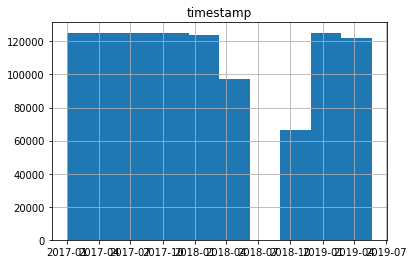

In [12]:
#Histogram of timestamps, should be even across the board
#Measured every minute
import matplotlib.pyplot as plt
%matplotlib inline
df.hist(column='timestamp')

array([[<AxesSubplot:title={'center':'weight'}>]], dtype=object)

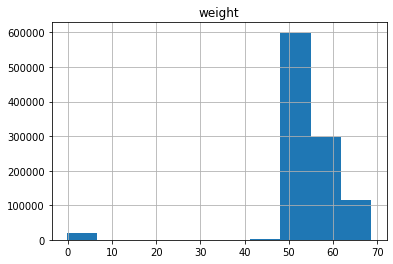

In [13]:
#And weight...
df.hist(column='weight')

In [14]:
#Seems like we have a bunch of outliers this time
#Q1 is 50, so let's just drop values that are really low
outliers = df.loc[df['weight']<45]
outliers

,timestamp,weight
115707,2017-03-22 13:42:00,-0.115216
115708,2017-03-22 13:43:00,-0.115216
115709,2017-03-22 13:44:00,-0.115216
185038,2017-05-09 18:13:00,44.951400
188789,2017-05-12 08:44:00,-0.083207
...,...,...
1028476,2019-05-15 10:40:00,-0.051902
1028477,2019-05-15 10:43:00,-0.051653
1028478,2019-05-15 10:44:00,-0.051653
1028479,2019-05-15 10:45:00,-0.051564


In [15]:
#Drop outliers
df.drop(df.loc[df['weight']<45].index, inplace = True)

In [16]:
#Any duplicates?
df[df.duplicated()].sum()

weight    563.2683
dtype: float64

In [17]:
#Not sure if we should drop duplicates still
df[df.duplicated()]

,timestamp,weight
433202,2017-10-29 02:07:00,56.2180
433214,2017-10-29 02:19:00,56.2180
433236,2017-10-29 02:41:00,56.2180
433237,2017-10-29 02:42:00,56.1540
433246,2017-10-29 02:51:00,56.1540
433249,2017-10-29 02:54:00,56.2180
433253,2017-10-29 02:58:00,56.1860
744837,2018-10-28 02:36:00,56.6341
744844,2018-10-28 02:43:00,56.6021
744855,2018-10-28 02:54:00,56.6661


In [18]:
#Show mean, standard dev, min, max, and IQRs after dropping rows
df.describe()

,weight
count,1.014648e+06
mean,5.471392e+01
std,4.937699e+00
min,4.501540e+01
25%,5.088870e+01
50%,5.375340e+01
75%,5.660210e+01
max,6.870240e+01


In [19]:
#Get median, mode, variance
print("median", df['weight'].median())
print("mode", mode(df['weight']).mode[0])
print("variance", df['weight'].var())

median 53.7534
mode 55.7059
variance 24.380867339467972


<AxesSubplot:xlabel='timestamp'>

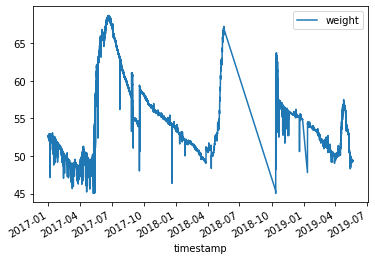

In [20]:
df.plot(x="timestamp", y="weight")